In [ ]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

root_dir = Path('/content/gdrive/MyDrive/Data')

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math
from tensorflow.keras import layers
import torch
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics
tf.random.set_seed(42)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def rotate_and_reverse(arr):
  arr_rotated = np.rot90(arr)
  return arr_rotated[::-1]

def chunk_up_psg(psg_df, freq=100):
  res = []
  for i in range(int(psg_df.shape[0]/(freq*30))):
    chunk = np.array(psg_df.iloc[i*freq*30:(i+1)*freq*30])
    chunk_rotated = rotate_and_reverse(chunk).reshape(-1)
    #print(chunk_rotated.shape)
    res.append(chunk_rotated)
  return np.array(res)

def downsample_data(data, rate=10):
  res = []
  for i in range(data.shape[0]):
    arr = np.zeros(int(data.shape[1]/rate))
    for j in range(int(data.shape[1]/rate)):
      arr[j] = torch.mean(data[i][j * rate : (j + 1) * rate])
    res.append(arr)
  return torch.from_numpy(np.array(res))

def get_N1_class_label(annot_df, label_map):
  res = []
  n = len(label_map.keys())
  for i in range(annot_df.shape[0]):
    N1_label = label_map[annot_df.iloc[i,0]]
    label = np.zeros(n)

    #for i in range(n):
    #  label[i][0] = 1
    #  if i == N1_label:
    #    label[i][0] = 0
    #    label[i][1] = 1
    label[N1_label] = 1
    res.append(label)
  return np.array(res)

def get_class_ids(annot_df, subject):
  return annot_df.index[annot_df['labels'] == subject].tolist()

def get_subject_psgs(psgs, annot_df, subject):
  indices = torch.tensor(get_class_ids(annot_df, subject))
  psg_subject = torch.index_select(psgs, 0, indices)
  return psg_subject

def gaussian_noise(data):
  mean, std = 0, torch.std(data) * 10 #torch.mean(data),
  noise = torch.tensor(np.random.normal(0, std)) #np.random.normal(mean, std, data.size()), dtype=torch.float32)
  return data + noise

def perm(data):
  permutation = random.sample(range(0, data.shape[1]), data.shape[1])
  return data[:, permutation]

def fft(data):
  return torch.fft.fft(data)

def augment_dataset(dataset, noise_times = 1):
  res = torch.cat((dataset, perm(dataset), fft(dataset), gaussian_noise(dataset)), 0)
  for i in range(1, noise_times):
    res = torch.cat((res, gaussian_noise(dataset)), 0)
  return res

def train_test_split(data, train=0.8, validation=0.1, test=0.1):
  data_len = data.shape[0]
  train_split = int(data_len * train)
  validation_split = int(data_len * (train + validation))
  return data[:train_split], data[train_split:validation_split], data[validation_split:]

def epochize_training_data(training_data, EPOCHS=32):
  res = []
  for i in range(math.ceil(training_data.shape[0]/EPOCHS)):
    epoch_chunk = training_data[i * EPOCHS: (i+1) * EPOCHS]
    res.append(epoch_chunk)
  return res

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)

    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      if (cf_matrix[i][j] == 0):
        cf_mat[i][j] = 0
      else:
        cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

In [ ]:
def make_dataset_for_subject(psgs, annot_df, label_map, target_subject,
                             ratio=0.2, val_portaion=0.1, test_portion=0.1):
  target_dataset = get_subject_psgs(psgs, annot_df, target_subject)
  n = target_dataset.shape[0]
  target_label = np.full((n, 2), [1, 0])
  no_labels = len(label_map.items())

  target_dataset_train, target_dataset_val, target_dataset_test = train_test_split(target_dataset)
  target_label_train, target_label_val, target_label_test = train_test_split(target_label)

  for subject, label in label_map.items():
    if subject == target_subject:
      continue;
    section_split = int(n * ratio / (no_labels-1))
    subject_dataset = get_subject_psgs(psgs, annot_df, subject)[:section_split]
    subject_label = np.full((subject_dataset.shape[0], 2), [0, 1])

    subject_dataset_train, subject_dataset_val, subject_dataset_test = train_test_split(subject_dataset)
    subject_label_train, subject_label_val, subject_label_test = train_test_split(subject_label)

    target_dataset_train = torch.cat((target_dataset_train, subject_dataset_train), 0)
    target_label_train = np.concatenate((target_label_train, subject_label_train), axis=0)
    target_dataset_val = torch.cat((target_dataset_val, subject_dataset_val), 0)
    target_label_val = np.concatenate((target_label_val, subject_label_val), axis=0)
    target_dataset_test = torch.cat((target_dataset_test, subject_dataset_test), 0)
    target_label_test = np.concatenate((target_label_test, subject_label_test), axis=0)

  return target_dataset_train, target_dataset_val, target_dataset_test, target_label_train, target_label_val, target_label_test


In [ ]:
save_psg = root_dir / Path("Sleep EDF Data/Processed/PSG.pkl")
save_annot = root_dir / Path("Sleep EDF Data/Processed/Annot.pkl")

psg_df = pd.read_pickle(save_psg)
annot_df = pd.read_pickle(save_annot)
psg_df.shape, annot_df.shape

psgs_orig = torch.from_numpy(chunk_up_psg(psg_df))
#psgs_orig = downsample_data(psgs_orig, 1)

psgs_orig.shape
psgs = psgs_orig * 1000000
#psgs = torch.round(psgs, decimals=3)
#psgs = psgs + 0.5

label_map = {'Sleep stage 1': 0,
            'Sleep stage 2': 1,
            'Sleep stage 3': 2,
            'Sleep stage 4': 3,
            'Sleep stage R': 4,
            'Movement time': 5,
            'Sleep stage W': 6}

N1_class_annot = get_N1_class_label(annot_df, label_map)
N1_class_annot.shape, N1_class_annot[:10]

psgs_N1 = get_subject_psgs(psgs, annot_df, 'Sleep stage 1')

N1_labels = N1_class_annot

target_dataset_train, target_dataset_val, target_dataset_test, target_label_train, target_label_val, target_label_test = make_dataset_for_subject(psgs, annot_df, label_map, 'Sleep stage 1', ratio=1)

target_dataset_train = target_dataset_train.unsqueeze(2)
target_dataset_final_train = target_dataset_train.numpy()

target_dataset_val = target_dataset_val.unsqueeze(2)
target_dataset_final_val = target_dataset_val.numpy()

target_dataset_test = target_dataset_test.unsqueeze(2)
target_dataset_final_test = target_dataset_test.numpy()
target_dataset_final_train.shape

(2496, 12000, 1)

Epoch 1/10
78/78 [==============================] - 29s 356ms/step - loss: 70.6157 - accuracy: 0.5649 - val_loss: 75.3119 - val_accuracy: 0.5545
Epoch 2/10
78/78 [==============================] - 28s 354ms/step - loss: 52.8192 - accuracy: 0.5966 - val_loss: 46.9485 - val_accuracy: 0.5865
Epoch 3/10
78/78 [==============================] - 28s 357ms/step - loss: 46.8478 - accuracy: 0.6210 - val_loss: 52.6711 - val_accuracy: 0.6026
Epoch 4/10
78/78 [==============================] - 27s 353ms/step - loss: 47.5631 - accuracy: 0.6394 - val_loss: 64.1960 - val_accuracy: 0.6346
Epoch 5/10
78/78 [==============================] - 28s 354ms/step - loss: 44.4278 - accuracy: 0.6607 - val_loss: 58.2593 - val_accuracy: 0.6378
Epoch 6/10
78/78 [==============================] - 27s 352ms/step - loss: 41.4902 - accuracy: 0.6627 - val_loss: 68.3023 - val_accuracy: 0.5641
Epoch 7/10
78/78 [==============================] - 28s 353ms/step - loss: 42.2221 - accuracy: 0.6935 - val_loss: 52.7199 - val_ac

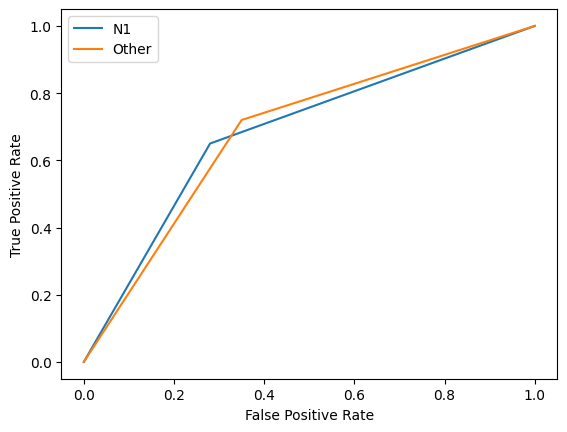

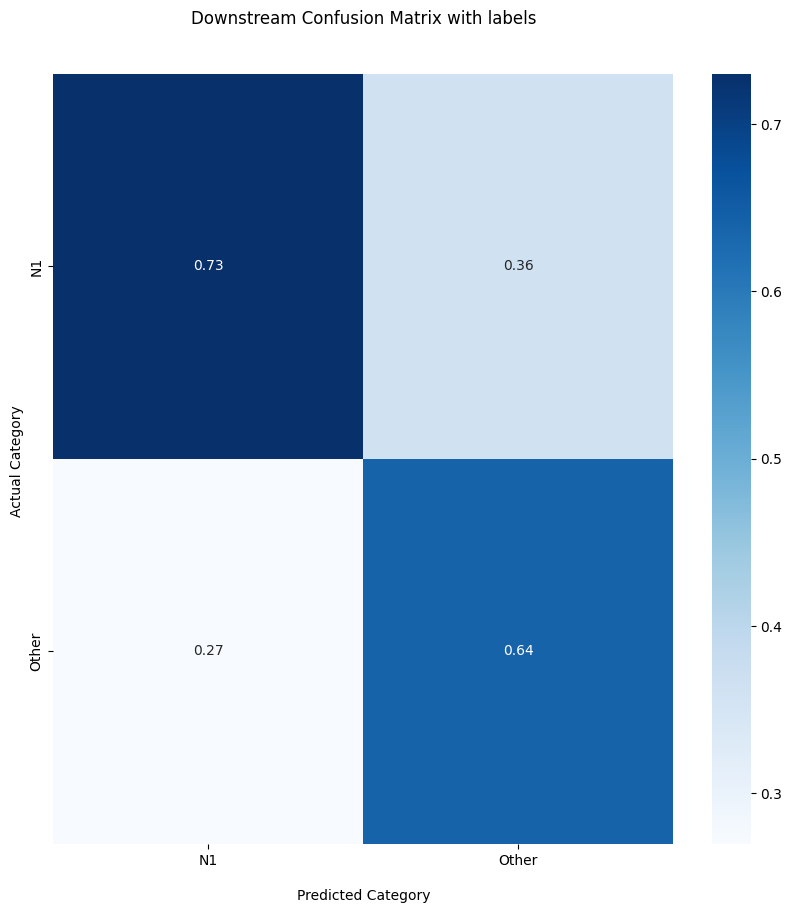

([0.73, 0.64], 0.68)

In [ ]:
tf.random.set_seed(42)
input = layers.Input((target_dataset_final_train.shape[1], 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv1D(64, 50, strides=16, activation="tanh", kernel_initializer='glorot_uniform')(input)
#x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)
x = layers.MaxPool1D(pool_size=8, strides=1)(x)
x = layers.Conv1D(128, 8, strides=1, activation="tanh", kernel_initializer='glorot_uniform')(x)
x = layers.Conv1D(128, 8, strides=1, activation="tanh", kernel_initializer='glorot_uniform')(x)
x = layers.Conv1D(128, 8, strides=1, activation="tanh", kernel_initializer='glorot_uniform')(x)
#x = layers.MaxPool1D(pool_size=2, strides=1)(x)
#x = layers.Conv2D(64, (1, 1), strides=(1, 1), activation="tanh", kernel_initializer='glorot_uniform')(x)
#x = layers.Flatten()(x)
#x = layers.LSTM(32, return_sequences=True)(x)
#x = layers.Dropout(0.5)(x)
#x = layers.LSTM(32, return_sequences=True)(x)
#x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)

input_1 = layers.Input((target_dataset_final_train.shape[1],1))
embedding_network = keras.Model(input, x)
tower_1 = embedding_network(input_1)

output_layer_1 = layers.Dense(2, activation="sigmoid")(tower_1)
output_layer_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_6 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_7 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
cnn = keras.Model(inputs=[input_1], outputs=[output_layer_1])

from tensorflow.keras.optimizers import RMSprop, SGD, Adam
rms = RMSprop(learning_rate=0.0005)
opt = RMSprop(learning_rate=0.01)
sgd = SGD(learning_rate=0.001)
cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

history_cnn = cnn.fit(
    target_dataset_final_train,
    target_label_train,
    validation_data=(target_dataset_final_val, target_label_val),
    batch_size=32,
    epochs=10,
)

test_labels = np.argmax(target_label_test, axis=1)
y_pred = np.argmax(cnn.predict(target_dataset_final_test), axis=1)
Labels = ['N1','Other']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)